# 2.0 - Mask GBIF data

In [6]:
from pathlib import Path

import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import shapes
import rioxarray as riox

### Clip the GBIF data


1. Convert `decimallatitude` and `decimallongitude` values to `shapely` `Point`s using `dask_geopandas.points_from_xy`
2. Convert `dask.DataFrame` to `dask_geopandas
3. Clip dataframe to the Germany mask


Prep filenames

In [ ]:
df_fn = Path("../data/raw/gbif/all_tracheophyta_non-cult_2024-01-21.parquet")

## Polygonize forest mask

In [8]:
def polygonize_raster(filename: str | Path) -> gpd.GeoDataFrame:
    """Polygonize a single-band raster image"""
    with rasterio.open(filename) as src:
        # Read the first band
        image = src.read(1)

        # Polygonize the raster
        results = (
            {"properties": {"raster_val": v}, "geometry": s}
            for i, (s, v) in enumerate(shapes(image, transform=src.transform))
        )

    # Convert the results to a GeoDataFrame
    return gpd.GeoDataFrame.from_features(list(results))

<Axes: >

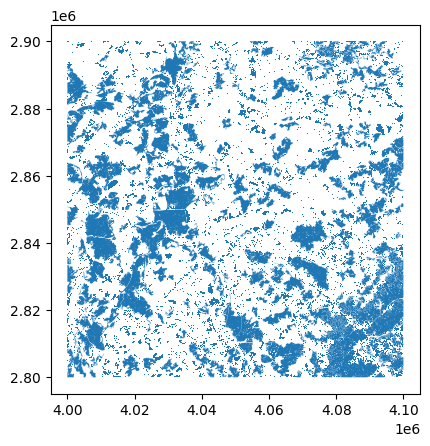

In [5]:
f_mask_fn = Path(
    "../data/raw/masks/forest_type_2018/FTY_2018_010m_de_03035_v010/DATA/FTY_2018_010m_E40N28_03035_v010.tif"
)

f_mask_gdf = polygonize_raster(f_mask_fn)

## Clip GBIF data by germany and forest masks

In [ ]:
cols = ["species", "decimallatitude", "decimallongitude"]
dtypes = {
    "species": str,
    "decimallatitude": np.float32,
    "decimallongitude": np.float32,
}


def clip_df_to_bbox(df: pd.DataFrame, mask: gpd.GeoDataFrame) -> pd.DataFrame:
    xmin, ymin, xmax, ymax = mask.total_bounds
    return df[
        (df["x"] >= xmin) & (df["y"] >= ymin) & (df["x"] <= xmax) & (df["y"] <= ymax)
    ]


clipped_gdf = (
    pd.read_parquet(df_fn, columns=cols)
    .astype(dtypes)
    .dropna()
    .rename(columns={"decimallongitude": "x", "decimallatitude": "y"})
    .pipe(clip_df_to_bbox, mask=de_mask)
    .assign(
        geometry=lambda df_: gpd.points_from_xy(
            df_["x"], df_["y"], crs="EPSG:4326"
        )
    )
    .drop(columns=["x", "y"])
    .pipe(lambda df_: gpd.GeoDataFrame(df_))
    .clip(de_mask)
    .to_crs(epsg=32632)
    .reset_index(drop=True)
)

In [ ]:
clipped_gdf.head()

,species,geometry
0,Vincetoxicum hirundinaria,POINT (8.45812 47.57488)
1,Angelica sylvestris,POINT (8.45812 47.57488)
2,Larix decidua,POINT (8.45812 47.57488)
3,Carex davalliana,POINT (8.45812 47.57488)
4,Fraxinus excelsior,POINT (8.45812 47.57488)
